In [75]:
#packages
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor

In [76]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [77]:
##Update this, its probably not where your DB is
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v4.db')

In [78]:
    cur = con.cursor()

    df = pd.read_sql("select calls_for_service.analysis_neighborhoods as neighborhood " \
        ", calls_for_service.call_number " \
        ", calls_for_service.incident_number " \
        ", floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con) 

In [79]:
#do some date math
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds) 
df['day_of_week'] = df['on_scene_dttm'].dt.dayofweek
df['dayflag'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)

df = df[df['dayflag'].notna()]
df = df[df['day_of_week'].notna()]

In [80]:
#rool up accessibility and minutes to zone
df_ag = df.groupby(["zone_idx","day_of_week", "dayflag"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
print(len(df_ag))
df_ag.head()

3515


,zone_idx,day_of_week,dayflag,accessibility_score,minutes
0,8,0.0,False,0.000803,7.283333
1,8,0.0,True,0.000803,7.289506
2,8,1.0,False,0.000803,2.916667
3,8,1.0,True,0.000803,14.403333
4,8,2.0,False,0.000803,3.583333


In [81]:
# hide the warings.
# I mean if it was really important it would just be an error, so blissfully ignore
warnings.filterwarnings('ignore')

# set the training variables
df_ag.target_to_predict = 'minutes'
df_ag.predictors = ['zone_idx', 'day_of_week', 'dayflag', 'accessibility_score']

df_ag.x = df_ag[df_ag.predictors].values
df_ag.y = df_ag[df_ag.target_to_predict].values

df_ag.x_train, df_ag.x_test, df_ag.y_train, df_ag.y_test = train_test_split(df_ag.x, df_ag.y, test_size=0.8, random_state=42)


In [82]:
#copy/paste code:

def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=300, subsample=0.5, colsample_bynode=0.8, min_child_weight=3)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('md.ytest', md.y_test)
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')



XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, enable_categorical=False, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=3,
               missing=nan, monotone_constraints=None, n_estimators=300,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.5,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.3409429469476596
md.ytest [2.68459596 4.14375    4.22727273 ... 3.64583333 3.36666667 3.05      ]
Accuracy 75.25234127397178
Accuracy -inf


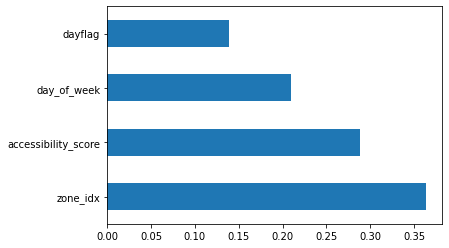

In [83]:
create_model(df_ag)

In [84]:
cur = con.cursor()
df_scenarios = pd.read_sql(('select distinct scenario_name from simulation_floating_catchment_output'), con=con)


In [85]:
prediction_stats = []
predictions = []
compare_errors = []

for i in range(len(df_scenarios)):
    #Get data to predict
    cur = con.cursor()
    scenario_name = df_scenarios["scenario_name"][i]
    day_of_week = 3
    dayFlag = True
    df_to_predict = pd.read_sql(('select zone_idx, accessibility_score, ? as day_of_week, ? as dayflag from simulation_floating_catchment_output where scenario_name = ?'), con=con,params=[day_of_week, dayFlag, scenario_name])
    #assumptions
    df_to_predict["dayflag"] = dayFlag
    df_to_predict["day_of_week"] = day_of_week
    print("Predicting: " + scenario_name + ", records:" + str(df_to_predict.count()))
    
    prediction = df_ag.XGB.predict(df_to_predict[["zone_idx", "accessibility_score", "day_of_week", "dayflag"]])
    print(len(prediction))
    df_to_predict['predicted_minutes'] = prediction.copy()

    compare_error = df_ag.merge(df_to_predict, how="inner", on=["zone_idx", "day_of_week","dayflag"])

    compare_error["minutes_delta"] = compare_error["minutes"] - compare_error["predicted_minutes"]
    compare_error["accessibility_delta"] = (compare_error["accessibility_score_x"] - compare_error["accessibility_score_y"])
    compare_error['scenario_name'] = scenario_name
    
    compare_errors.append(compare_error.copy())
    sq_error_sum = np.sum(np.square(np.array(compare_error["minutes"]) - np.array(compare_error["predicted_minutes"])))
    sq_error_mean = np.sum(np.square(np.average(compare_error["minutes"]) - np.array(compare_error["minutes"])))

    (r, p) = scipy.stats.pearsonr(compare_error["minutes_delta"], compare_error["accessibility_delta"])

    prediction_stats.append((scenario_name, sq_error_sum.copy(), sq_error_mean.copy(), r,p))
    df_to_predict["scenario_name"] = scenario_name
    predictions.append(df_to_predict.copy())
    
    




Predicting: new_station_235, records:zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64
265
Predicting: new_station_177, records:zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64
265
Predicting: new_station_176, records:zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64
265
Predicting: new_station_319, records:zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64
265
Predicting: new_station_274, records:zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64
265
Predicting: new_station_271, records:zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64
265
Predicting: new_station_292,

In [86]:
print(pd.concat(compare_errors)[['minutes_delta', 'accessibility_delta', 'scenario_name', 'zone_idx']].to_csv('delta_analysis_dayflag_original_parameters.csv'))

None


In [87]:
sts = pd.DataFrame(prediction_stats)
sts = sts.rename(columns={0: "scenario_name", 1: "sq_avg_error", 2:"sq_sum_error", 3:"r_value",4:"p_value"}, errors="raise")

sts.to_csv('prediction_stats.csv')


In [88]:
pd.concat(predictions).to_csv('predictions.csv')

In [89]:
df_ag.to_csv('aggregated.csv')